## Introduction

This notebook is adapted from [Laurent Veyssier's notebook](https://github.com/LaurentVeyssier/Semantic-Segmentation-with-Fully-Convolution-Network). It implements the Semantic Segmentation algorithm introduced in [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038). The following changes are made to the original notebook:

- Use Dataset and DataLoader instead of writing them from scratch
- Add data augmentation
- Add IoU as a metric
- Add evaluation dataset and dataloader

In [ ]:
!pip install torchsummary

In [250]:
import os
import helper
import math
import random
import re
import sys
import warnings

import cv2
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchsummary import summary

## Dataset

We use [KITTI road segmentation dataset](https://www.cvlibs.net/datasets/kitti/eval_road.php), which can be downloaded from [here](https://www.cvlibs.net/download.php?file=data_road.zip).

In [ ]:
# Download KITTI-Road-Segmentation dataset
! mkdir -p ./data
! wget -O ./data/data_road.zip https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
! unzip ./data/data_road.zip -d ./data

In [176]:
# solution from: https://github.com/NielsRogge/transformers/blob/add_semantic_script/examples/pytorch/semantic-segmentation/run_semantic_segmentation.py
class Compose:
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, target):
    for t in self.transforms:
      image, target = t(image, target)
    return image, target

class Resize:
  def __init__(self, size):
    self.size = size

  def __call__(self, image, target):
    image = TF.resize(image, self.size)
    target = TF.resize(target, self.size)
    return image, target

class RandomHorizontalFlip:
  def __init__(self, flip_prob=0.5):
    self.flip_prob = flip_prob

  def __call__(self, image, target):
    if random.random() < self.flip_prob:
      image = TF.hflip(image)
      target = TF.hflip(target)
    return image, target

class RandomVerticalFlip:
  def __init__(self, flip_prob=0.5):
    self.flip_prob = flip_prob

  def __call__(self, image, target):
    if random.random() < self.flip_prob:
      image = TF.vflip(image)
      target = TF.vflip(target)
    return image, target

class RandomRotate:
  def __init__(self, degrees):
    self.degrees = degrees

  def __call__(self, image, target):
    angle = float(torch.empty(1).uniform_(float(self.degrees[0]), float(self.degrees[1])).item())
    image = TF.rotate(image, angle)
    target = TF.rotate(target, angle)
    return image, target

class ToPILImage:
  def __call__(self, image, target):
    image = TF.to_pil_image(image)
    target = TF.to_pil_image(target)
    return image, target

class ToTensor:
  def __call__(self, image, target):
    image = TF.to_tensor(image)
    target = torch.as_tensor(np.array(target), dtype=torch.uint8)
    return image, target

In [58]:
## --------- test --------------
%%script false --no-raise-error
image_file = './data/data_road/training/image_2/um_000011.png'
target_file = './data/data_road/training/gt_image_2/um_road_000011.png'
image = io.imread(image_file)
image = transforms.ToPILImage()(image)
target = io.imread(target_file)
target = transforms.ToPILImage()(target)

tfm = RandomRotate([-45, 45])
image, target = tfm(image, target)

figure = plt.figure(figsize=(20, 20))
figure.add_subplot(1,2,1)
plt.imshow(image)
figure.add_subplot(1,2,2)
plt.imshow(target)
plt.show()

In [59]:
## --------- test --------------
%%script false --no-raise-error
image_file = './data/data_road/training/image_2/um_000011.png'
target_file = './data/data_road/training/gt_image_2/um_road_000011.png'
image = io.imread(image_file)
print(image.shape, image.dtype)
image = transforms.ToPILImage()(image)

tfm = ToTensor()
image, _ = tfm(image, image)
print(image.shape, image.dtype)
print('image scale: \tMin: ', image.min(), '\tMax: ', image.max())

(375, 1242, 3) uint8
torch.Size([3, 375, 1242]) torch.float32
image scale: 	Min:  tensor(0.) 	Max:  tensor(1.)


In [258]:
IMG_SZ = 256
image_shape = (256, 256)
train_tfm = Compose([
    ToPILImage(),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    # RandomRotate([-45, 45]),
    # Resize the image into a fixed shape (height = width = IMG_SZ)
    Resize((IMG_SZ, IMG_SZ)),
    # ToTensor() should be the last one of the transforms.
    ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.ToPILImage(),
    # Resize the image into a fixed shape (height = width = IMG_SZ)
    transforms.Resize((IMG_SZ, IMG_SZ)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

<class 'numpy.ndarray'> uint8 (375, 1242, 3)
<class 'torch.Tensor'> torch.uint8 torch.Size([375, 1242, 3])
<class 'torch.Tensor'> torch.bool torch.Size([375, 1242])
<class 'torch.Tensor'> torch.bool torch.Size([375, 1242, 1])
<class 'torch.Tensor'> torch.float32 torch.Size([375, 1242, 2])


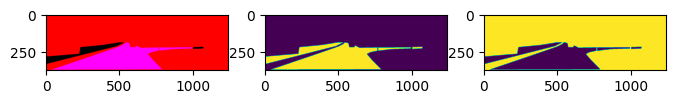

(tensor([255,   0,   0], dtype=torch.uint8), tensor([1., 0.]))

In [62]:
## --------- test --------------
%%script false --no-raise-error
background_color = torch.tensor([255, 0, 0])
# image_file = '/content/data/data_road/training/gt_image_2/um_road_000058.png'
image_file = './data/data_road/training/gt_image_2/um_road_000011.png'
image = io.imread(image_file)
print(type(image), image.dtype, image.shape)
image = torch.from_numpy(image)
print(type(image), image.dtype, image.shape)
# image = np.asarray(image)
# print(type(image), image.dtype, image.shape)
bg = torch.all(image == background_color, axis=2)
print(type(bg), bg.dtype, bg.shape)
bg = bg.unsqueeze(-1)
print(type(bg), bg.dtype, bg.shape)
label = torch.concatenate((bg, ~bg), axis=2).float()
print(type(label), label.dtype, label.shape)
figure = plt.figure(figsize=(8,8))
figure.add_subplot(1,3,1)
plt.imshow(image)
figure.add_subplot(1,3,2)
plt.imshow(label[:,:,1])
figure.add_subplot(1,3,3)
plt.imshow(bg)
plt.show()
image[0,0], label[0, 0]

In [259]:
class SegmentationDataset(Dataset):
  def __init__(self, data_folder, mode, transform=None):
    self.image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
    self.label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
                        for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
    self.mode = mode
    self.transform = transform
    self.background_color = np.array([255, 0, 0]) # Background is in red.

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_file = self.image_paths[idx]
    image = io.imread(image_file)

    if self.mode == 'train':
      gt_image_file = self.label_paths[os.path.basename(image_file)]
      gt_image = io.imread(gt_image_file)                                   # shape H x W x 3

      # Create "one-hot-like" labels by class
      gt_bg = np.all(gt_image == self.background_color, axis=2)             # mask H x W with background from gt_image
      label = ~gt_bg
      label = label.astype('uint8')

    if self.transform:
      if self.mode == 'train':
        image, label = self.transform(image, label)
      else:
        image = self.transform(image)

    if self.mode == 'train':
      # add one dim to 1 x H x W
      # labels format 2, H, W - Bkg in 0, road in 1
      label = label.reshape(1, *label.shape)
      label = torch.concatenate((label, label), axis=0)
      label[1, label[1] == 0] = 2
      label[1, label[1] == 1] = 0
      label[1, label[1] == 2] = 1

    if self.mode == 'train':
      return image, label.float()
    return image


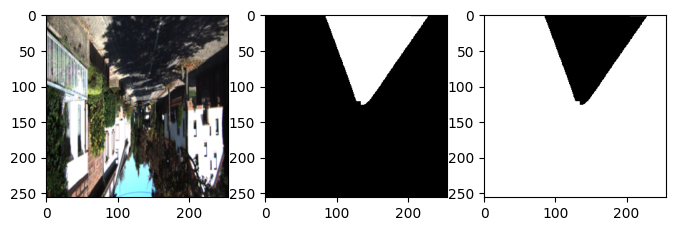

In [260]:
%%script false --no-raise-error
test_dataset = SegmentationDataset('./data/data_road/training', 'train', train_tfm)
figure = plt.figure(figsize=(8,8))
for i, sample in enumerate(test_dataset):
  image, label = sample
  image = torch.permute(image, (1, 2, 0))
  label = torch.permute(label, (1, 2, 0))
  figure.add_subplot(1,3,1)
  plt.imshow(image)
  figure.add_subplot(1,3,2)
  plt.imshow(label[:,:,0], cmap='gray')
  figure.add_subplot(1,3,3)
  plt.imshow(label[:,:,1], cmap='gray')
  break
plt.show()

## DataLoader

In [242]:
train_ds = SegmentationDataset('./data/data_road/training', 'train', train_tfm)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)

In [243]:
img, label = train_dl.dataset[4]
print('image scale: \tMin: ', img.min(), '\tMax: ', img.max())       # image scale from 0. to 1. expected by pretrained model
print('label scale: \tMin: ', label.min(), '\tMax: ', label.max())   # label scale from 0. to 255.

image scale: 	Min:  tensor(0.0118) 	Max:  tensor(1.)
label scale: 	Min:  tensor(0.) 	Max:  tensor(1.)


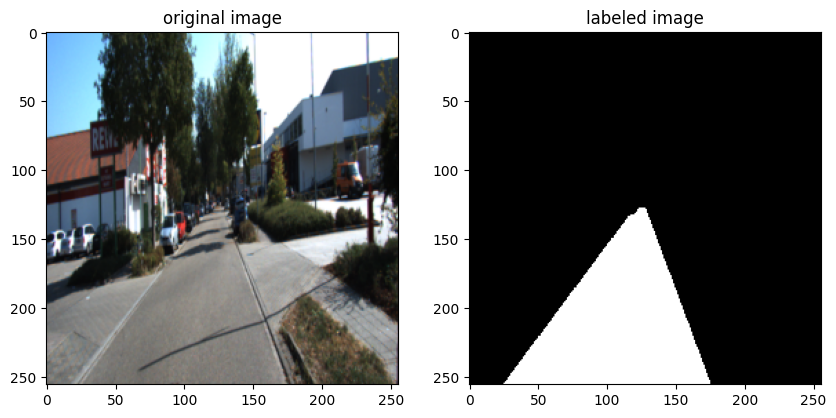

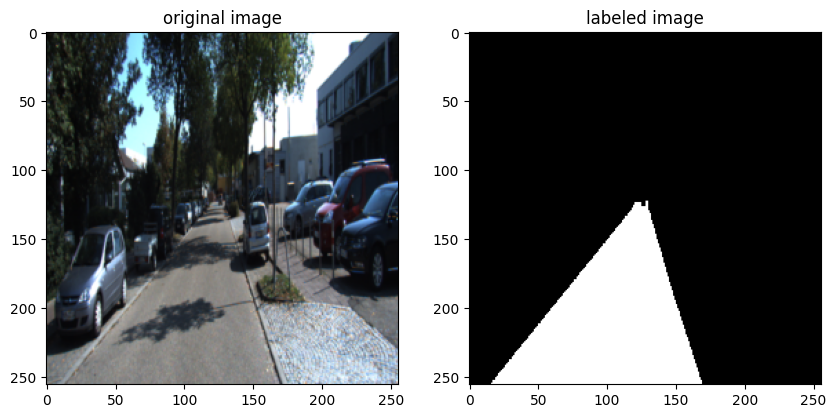

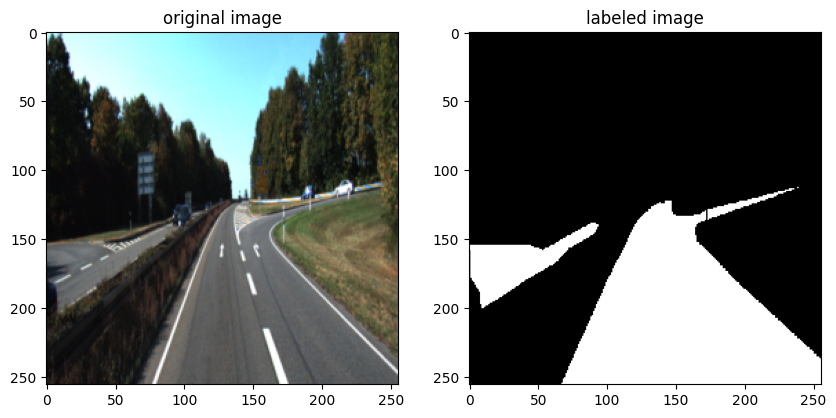

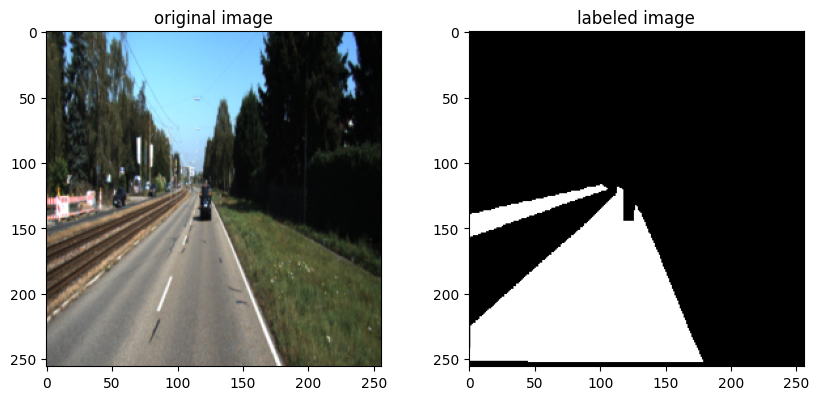

In [244]:
for batch_i, batch in enumerate(train_dl):
  images, labels = batch
  for i in range(4):
    plt.figure(figsize=(10, 20))

    plt.subplot(i+1, 2, 1)
    img = np.copy(images[i])
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.title('original image')

    plt.subplot(i+1, 2, 2)
    lab = np.array(labels[i], dtype=np.uint8)
    lab = np.transpose(lab, (1,2,0))
    plt.imshow(lab[:,:,0], cmap='gray')
    plt.title('labeled image')

    plt.show()
  break

In [ ]:
## --------- deprecated --------------
%%script false --no-raise-error
# Replace with Dataset and DataLoader class
def gen_batch_function(mode, image_shape):
  """
  Generate function to create batches of training data
  """

  if mode == 'train':
    data_folder = os.path.join(data_dir, 'data_road/training')
  elif mode == 'test':
    data_folder = os.path.join(data_dir, 'data_road/testing')
  else:
    warnings.warn("No mode selected, please select either 'train' or 'test'")

  transform_img = transforms.Compose([transforms.ToTensor()])
  transform_label = transforms.Compose([transforms.ToTensor()])

  def get_batches_fn(batch_size):
    """Create batches of training data."""
    image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))

    if mode == 'train':
      label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
                     for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
      background_color = np.array([255, 0, 0]) # BGR format since use of cv2 to read images.

    random.shuffle(image_paths)

    for batch_i in range(0, len(image_paths), batch_size):
      images = torch.zeros([batch_size, 3, image_shape[0], image_shape[1]])
      if mode == 'train':
        gt_images = np.zeros([batch_size, image_shape[0], image_shape[1], 3])
        labels = torch.zeros([batch_size, 2, image_shape[0], image_shape[1]])

      for idx, image_file in enumerate(image_paths[batch_i:batch_i+batch_size]):
        image = io.imread(image_file)
        image = np.asarray(image)

        if mode == 'train':
          gt_image_file = label_paths[os.path.basename(image_file)]
          gt_image = io.imread(gt_image_file)  # shape H x W x 3 but BGR
          gt_image = np.array(gt_image, dtype=np.uint8)
          gt_image = np.asarray(gt_image)      # ground_truth images format H, W, 3 - data ndarray type

          # Create "one-hot-like" labels by class
          gt_bg = np.all(gt_image == background_color, axis=2)       # mask H x W with background from gt_image

          gt_bg = gt_bg.reshape(*gt_bg.shape, 1)                     # add one dim to H x W x 1
          label = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)  # labels format H, W, 2 - Bkg in 0, road in 1
          label = label.astype("float")

        image = cv2.resize(image, (image_shape[1], image_shape[0]))
        if mode == 'train':
          gt_image = cv2.resize(gt_image, (image_shape[1], image_shape[0]))
          label = cv2.resize(label, (image_shape[1], image_shape[0]))

        image = transform_img(image)

        if mode == 'train':
          label = label.transpose(2, 0, 1)
          label = torch.from_numpy(label)

        images[idx,:,:,:] = image
        if mode == 'train':
          gt_images[idx,:,:,:] = gt_image
          labels[idx,:,:,:] = label

      if mode == 'train':
        yield images, labels, gt_images
      else:
        yield images, image_paths[batch_i:batch_i+batch_size]

  return get_batches_fn

In [ ]:
## --------- deprecated --------------
%%script false --no-raise-error
data_dir = './data'
image_shape = (256, 256) # H x W, KITTI dataset uses 160x576 images to resize to 224 minimum
batch_size = 8

# get dataloader
get_batches_fn = gen_batch_function('train', image_shape)

# obtain one batch of training images
images, labels, gt_images = next(get_batches_fn(batch_size))

In [162]:
## --------- deprecated --------------
%%script false --no-raise-error
# current range
img = images[4]
print('image scale: \tMin: ', img.min(), '\tMax: ', img.max())       # image scale from 0. to 1. expected by pretrained model
label = labels[4]
print('label scale: \tMin: ', label.min(), '\tMax: ', label.max())   # label scale from 0. to 255.

# Display sample images
plt.figure(figsize=(20,40))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = np.copy(images[i])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
plt.show()
print('shape of images as tensor\t 3 x H x W: \t', images[0].shape)
print('shape of labels as tensor\t  2 x H x W: \t', labels[0].shape)
print()

for i in range(4):

    plt.figure(figsize=(20,40))

    plt.subplot(i+1,3,1)
    img = np.copy(images[i])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title('original image')

    plt.subplot(i+1,3,2)
    gt = np.array(gt_images[i], dtype=np.uint8)
    plt.imshow(gt)
    plt.title('labeled image')

    plt.subplot(i+1,3,3)
    label = np.transpose(labels[i], (1, 2, 0))
    plt.imshow(label[:,:,1], cmap='gray')
    plt.title('input mask (in grayscale)')

    plt.show()

image_shape = (images[0].shape[1],images[0].shape[2]) # update W, H to new values
print('\nUpdated image shape in dataloader W x H :', image_shape)

## Going deep with PyTorch

https://blog.paperspace.com/pytorch-101-advanced/

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
print(vgg._modules)
print()
print('layer 0 or input layer: ', vgg._modules['0'])

OrderedDict([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
print(vgg._modules['features'])
print()
print('layer 0 or input layer: ', vgg._modules['features'][0])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
print('CHILDREN')
print(list(vgg.children()))
print()
print('MODULES')
print(list(vgg.modules()))
print()
print('NAMED_MODULES')
for x in vgg.named_modules():
  print(x[0], x[1], '\n-----------------------')
print()
print('NAMED_CHILDREN')
for x in vgg.named_children():
  print(x[0], x[1], '\n-----------------------')

CHILDREN
[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512,

## Model Architecture

In [148]:
class Encoder(nn.Module):
  def __init__(self, vgg_path):
    super(Encoder, self).__init__()

    self.vgg_path = vgg_path

    if self.vgg_path != None and os.path.exists(os.path.join(self.vgg_path, 'saved_model.pt')):
      model_file = os.path.join(self.vgg_path, 'saved_model.pt')
      vgg.load_state_dict(torch.load(model_file))
    else:
      # Keep the top Conv feature section, and drop the head Linear section.
      self.vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features

      # freeze parameters of pre-trained VGG16 model
      for param in self.vgg.parameters():
        param.requires_grad = False

      self.vgg_path = './data/saved_model'
      model_file = os.path.join(self.vgg_path, 'saved_model.pt')
      if not os.path.exists(model_file):
        try:
          !mkdir -p data/saved_model
          torch.save(self.vgg.state_dict(), model_file)
        except:
          torch.save(self.vgg.state_dict(), model_file)

      if not torch.cuda.is_available():
        summary(self.vgg, (3, 375, 1242))
      else:
        print(self.vgg)

  def forward(self, images):
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    layers = {'16': 'MaxPool2d_3_out',
              '23': 'MaxPool2d_4_out',
              '30': 'MaxPool2d_7_out'}

    features = {}

    x = images
    for idx in range(len(self.vgg._modules)):
      layer = self.vgg._modules[str(idx)]
      x = layer(x)
      if str(idx) in layers.keys():
        features[layers[str(idx)]] = x

    return features['MaxPool2d_3_out'], features['MaxPool2d_4_out'], features['MaxPool2d_7_out']


In [ ]:
class Decoder(nn.Module):
  def __init__(self, num_classes=2):
    super(Decoder, self).__init__()

    ## Decoder params
    self.vgg_layer3_depth = 256
    self.vgg_layer4_depth = 512
    self.vgg_layer7_depth = 512
    self.num_classes = num_classes
    self.height = image_shape[0]
    self.width = image_shape[1]

    # Build 1x1 conv sampling and skip connections
    self.skip_vgg_layer4 = nn.Conv2d(in_channels = self.vgg_layer4_depth, out_channels = 256,
                                     kernel_size = (1, 1), stride = 1, padding = 0)
    self.skip_vgg_layer3 = nn.Conv2d(in_channels = self.vgg_layer3_depth, out_channels = 128,
                                     kernel_size = (1, 1), stride = 1, padding = 0)

    # BatchNorm layers
    self.bn1 = nn.BatchNorm2d(256)
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(32)
    self.bn5 = nn.BatchNorm2d(16)

    # build decoder
    self.deconv1 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv2 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv3 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv4 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv5= nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.AMP = nn.AdaptiveMaxPool3d(output_size = (2, self.height, self.width))

    # Initialize decoder layers using Xavier's initialization
    self.model_init()

    # To provide lisibility, print tensor dimension when instantiating the model
    self.print_tensor_dims = True

  def forward(self, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out):
    self.batch_size = vgg_layer3_out.shape[0]
    self.vgg_layer3_out = vgg_layer3_out
    self.vgg_layer4_out = vgg_layer4_out
    self.vgg_layer7_out = vgg_layer7_out

    if self.print_tensor_dims: print('VGG F-32 output dims in: \t\t\t\t\t', self.vgg_layer7_out.shape)

    self.vgg_layer4_logits = self.skip_vgg_layer4(self.vgg_layer4_out)

    if self.print_tensor_dims: print('VGG F-16 output dims in: \t\t\t\t\t', self.vgg_layer4_out.shape)

    self.vgg_layer3_logits = self.skip_vgg_layer3(self.vgg_layer3_out)

    if self.print_tensor_dims: print('VGG F-8 output dims in: \t\t\t\t\t', self.vgg_layer3_out.shape)

    # Feed forward decoder

    # Upsampling by 2
    x = F.relu_(self.deconv1(self.vgg_layer7_out))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv1 : \t\t', x.shape)

    # Skip connection
    x = self.bn1(x.add(self.vgg_layer4_logits))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv1 + skip FCN-16 : \t\t', x.shape)

    # Upsampling by 2
    x = F.relu_(self.deconv2(x))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv2 : \t\t', x.shape)

    # Skip connection
    x = self.bn2(x.add(self.vgg_layer3_logits))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv2 + skip FCN-8 : \t\t', x.shape)

    # Upsampling by 8
    x = self.bn3(F.relu_(self.deconv3(x)))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv3 : \t\t', x.shape)

    # Upsampling by 16
    x = self.bn4(F.relu_(self.deconv4(x)))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv4 : \t\t', x.shape)

    # Upsampling by 32
    x = self.bn5(F.relu_(self.deconv5(x)))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv5 : \t\t', x.shape)

    # Bring feature depth to num_classes
    output = self.AMP(x)

    # We ensure appropriate tensor shape: batch_size x num_classes x H x W
    output = output.view(self.batch_size, self.num_classes, self.height, self.width)
    if self.print_tensor_dims: print('Dims of prediction AMP output : \t\t', x.shape)

    self.print_tensor_dims = False
    return output

  def model_init(self):
    torch.nn.init.xavier_uniform_(self.deconv1.weight)
    torch.nn.init.xavier_uniform_(self.deconv2.weight)
    torch.nn.init.xavier_uniform_(self.deconv3.weight)
    torch.nn.init.xavier_uniform_(self.deconv4.weight)
    torch.nn.init.xavier_uniform_(self.deconv5.weight)

In [261]:
all_train_ds = SegmentationDataset('./data/data_road/training', 'train', train_tfm)
train_size = int(0.8 * len(all_train_ds))
valid_size = len(all_train_ds) - train_size

train_ds, valid_ds = torch.utils.data.random_split(all_train_ds, [train_size, valid_size])
print(f'all train ds size: {len(all_train_ds)}, train ds size: {len(train_ds)}, valid ds size: {len(valid_ds)}')

batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

all train ds size: 289, train ds size: 231, valid ds size: 58


In [262]:
num_classes = 2
encoder = Encoder(None)
decoder = Decoder(num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
decoder.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(decoder.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [247]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('total number of trainable parameters for encoder [%d] and decoder [%d]'
      %(count_parameters(encoder), count_parameters(decoder)))

total number of trainable parameters for encoder [0] and decoder [864080]


In [248]:
def cmp_iou(pred, target, cls):
  ious = []
  n, _, _ = pred.shape

  pred = pred.view(n, -1)
  pred[pred > 0.5] = 1

  target = target.reshape(n, -1)

  for i in range(n):
    pred_inds = pred[i] == cls
    target_inds = target[i] == cls
    intersection = (pred_inds[target_inds]).long().sum().item()
    union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
    if union == 0:
      ious.append(float('nan'))
    else:
      ious.append(intersection / union)

  return ious

In [263]:
! mkdir -p ./data/seg_saved_models

num_epochs = 40
patience = 20
ckpt_name = './data/seg_saved_models/best.ckpt'
best_iou = 0
stale = 0

for epoch in range(num_epochs):
  decoder.train()
  train_losses = []
  train_ious = []

  for batch in tqdm(train_dl):
    images, labels = batch

    images = images.to(device)
    labels = labels.to(device)

    encoder.zero_grad()
    decoder.zero_grad()
    # optimizer.zero_grad()

    # Forward pass.
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
    outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)

    # Calculate the batch loss.
    loss = criterion(outputs, labels)

    # Backward pass.
    loss.backward()

    # Update parameters.
    optimizer.step()

    train_losses.append(loss.item())
    ious = cmp_iou(outputs[:, 0], labels[:, 0], 1)
    train_ious.extend(ious)

  train_loss = sum(train_losses) / len(train_losses)
  train_iou = sum(train_ious) / len(train_ious)
  print(f"[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss:.5f} iou = {train_iou:.5f}")

  decoder.eval()
  valid_losses = []
  valid_ious = []

  for batch in tqdm(valid_dl):
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      # Forward pass.
      vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
      outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)

      # Calculate the batch loss.
      loss = criterion(outputs, labels)

      valid_losses.append(loss.item())
      ious = cmp_iou(outputs[:, 0], labels[:, 0], 1)
      valid_ious.extend(ious)
  valid_loss = sum(valid_losses) / len(valid_losses)
  valid_iou = sum(valid_ious) / len(valid_ious)
  print(f'[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}')

  msg = f'[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}'
  msg += ' -> best' if valid_iou > best_iou else ''
  with open(f'./data/log.txt', 'a') as fid:
    fid.write(msg+'\n')

  if valid_iou > best_iou:
    print(f'Best model found at epoch {epoch+1:03d}, saving model')
    torch.save(decoder.state_dict(), ckpt_name)
    best_iou = valid_iou
    stale = 0
  else:
    stale += 1
    if stale > patience:
      print(f'No improvment {patience} consecutive epochs, early stopping')
      break;

  0%|          | 0/8 [00:00<?, ?it/s]

VGG F-32 output dims in: 					 torch.Size([32, 512, 8, 8])
VGG F-16 output dims in: 					 torch.Size([32, 512, 16, 16])
VGG F-8 output dims in: 					 torch.Size([32, 256, 32, 32])
Dims of Decoder upsampling output deconv1 : 		 torch.Size([32, 256, 16, 16])
Dims of Decoder upsampling output deconv1 + skip FCN-16 : 		 torch.Size([32, 256, 16, 16])
Dims of Decoder upsampling output deconv2 : 		 torch.Size([32, 128, 32, 32])
Dims of Decoder upsampling output deconv2 + skip FCN-8 : 		 torch.Size([32, 128, 32, 32])
Dims of Decoder upsampling output deconv3 : 		 torch.Size([32, 64, 64, 64])
Dims of Decoder upsampling output deconv4 : 		 torch.Size([32, 32, 128, 128])
Dims of Decoder upsampling output deconv5 : 		 torch.Size([32, 16, 256, 256])
Dims of prediction AMP output : 		 torch.Size([32, 16, 256, 256])
[ Train | 001/040 ] loss = 0.97471 iou = 0.18002


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 001/040 ] loss = 0.77428 iou = 0.11007
Best model found at epoch 001, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 002/040 ] loss = 0.79534 iou = 0.15068


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 002/040 ] loss = 0.91500 iou = 0.13712
Best model found at epoch 002, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 003/040 ] loss = 0.68224 iou = 0.17801


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 003/040 ] loss = 0.77571 iou = 0.27705
Best model found at epoch 003, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 004/040 ] loss = 0.59558 iou = 0.33879


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 004/040 ] loss = 0.60916 iou = 0.41208
Best model found at epoch 004, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 005/040 ] loss = 0.51616 iou = 0.47470


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 005/040 ] loss = 0.50493 iou = 0.51279
Best model found at epoch 005, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 006/040 ] loss = 0.45325 iou = 0.56236


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 006/040 ] loss = 0.44387 iou = 0.56737
Best model found at epoch 006, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 007/040 ] loss = 0.41176 iou = 0.61514


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 007/040 ] loss = 0.41503 iou = 0.58623
Best model found at epoch 007, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 008/040 ] loss = 0.39044 iou = 0.63930


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 008/040 ] loss = 0.40373 iou = 0.60631
Best model found at epoch 008, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 009/040 ] loss = 0.37619 iou = 0.65207


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 009/040 ] loss = 0.39362 iou = 0.59281


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 010/040 ] loss = 0.37015 iou = 0.66231


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 010/040 ] loss = 0.38323 iou = 0.60424


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 011/040 ] loss = 0.36601 iou = 0.66928


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 011/040 ] loss = 0.37297 iou = 0.61972
Best model found at epoch 011, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 012/040 ] loss = 0.35417 iou = 0.67631


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 012/040 ] loss = 0.37277 iou = 0.61334


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 013/040 ] loss = 0.35008 iou = 0.68319


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 013/040 ] loss = 0.36945 iou = 0.62283
Best model found at epoch 013, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 014/040 ] loss = 0.34638 iou = 0.68078


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 014/040 ] loss = 0.36027 iou = 0.60997


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 015/040 ] loss = 0.34000 iou = 0.69216


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 015/040 ] loss = 0.35949 iou = 0.61403


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 016/040 ] loss = 0.34077 iou = 0.69210


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 016/040 ] loss = 0.36255 iou = 0.63234
Best model found at epoch 016, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 017/040 ] loss = 0.33502 iou = 0.69215


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 017/040 ] loss = 0.35280 iou = 0.61604


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 018/040 ] loss = 0.33607 iou = 0.69619


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 018/040 ] loss = 0.34885 iou = 0.62890


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 019/040 ] loss = 0.33245 iou = 0.70800


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 019/040 ] loss = 0.35674 iou = 0.64223
Best model found at epoch 019, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 020/040 ] loss = 0.32867 iou = 0.70730


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 020/040 ] loss = 0.34754 iou = 0.62729


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 021/040 ] loss = 0.32658 iou = 0.71456


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 021/040 ] loss = 0.34391 iou = 0.63595


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 022/040 ] loss = 0.32089 iou = 0.72022


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 022/040 ] loss = 0.34213 iou = 0.64744
Best model found at epoch 022, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 023/040 ] loss = 0.31961 iou = 0.72361


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 023/040 ] loss = 0.34341 iou = 0.64899
Best model found at epoch 023, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 024/040 ] loss = 0.31761 iou = 0.72437


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 024/040 ] loss = 0.34975 iou = 0.64421


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 025/040 ] loss = 0.31360 iou = 0.73021


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 025/040 ] loss = 0.33581 iou = 0.64450


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 026/040 ] loss = 0.31321 iou = 0.73217


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 026/040 ] loss = 0.33425 iou = 0.63696


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 027/040 ] loss = 0.30933 iou = 0.73767


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 027/040 ] loss = 0.33670 iou = 0.65027
Best model found at epoch 027, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 028/040 ] loss = 0.30974 iou = 0.74124


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 028/040 ] loss = 0.33643 iou = 0.66214
Best model found at epoch 028, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 029/040 ] loss = 0.30497 iou = 0.74408


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 029/040 ] loss = 0.32838 iou = 0.65877


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 030/040 ] loss = 0.30220 iou = 0.74853


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 030/040 ] loss = 0.32508 iou = 0.65471


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 031/040 ] loss = 0.29991 iou = 0.75095


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 031/040 ] loss = 0.32424 iou = 0.66754
Best model found at epoch 031, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 032/040 ] loss = 0.29960 iou = 0.75499


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 032/040 ] loss = 0.33154 iou = 0.66626


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 033/040 ] loss = 0.29698 iou = 0.75126


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 033/040 ] loss = 0.32405 iou = 0.66112


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 034/040 ] loss = 0.29697 iou = 0.75659


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 034/040 ] loss = 0.32039 iou = 0.65701


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 035/040 ] loss = 0.29328 iou = 0.76300


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 035/040 ] loss = 0.31640 iou = 0.67585
Best model found at epoch 035, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 036/040 ] loss = 0.29119 iou = 0.76389


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 036/040 ] loss = 0.31879 iou = 0.67934
Best model found at epoch 036, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 037/040 ] loss = 0.29068 iou = 0.77112


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 037/040 ] loss = 0.31735 iou = 0.67200


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 038/040 ] loss = 0.28607 iou = 0.77705


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 038/040 ] loss = 0.31611 iou = 0.67742


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 039/040 ] loss = 0.28609 iou = 0.77663


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 039/040 ] loss = 0.31567 iou = 0.66657


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 040/040 ] loss = 0.28470 iou = 0.77264


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 040/040 ] loss = 0.31160 iou = 0.68301
Best model found at epoch 040, saving model


In [ ]:
## --------- deprecated --------------
%%script false --no-raise-error
! mkdir -p ./data/seg_saved_models

for epoch in range(num_epochs):
  for i in range(1, total_steps+1):
    images, labels, _ = next(iter(get_batches_fn(batch_size)))
    print(images.shape, images.dtype, labels.shape, labels.dtype)

    images = images.to(device)
    labels = labels.to(device)

    encoder.zero_grad()
    decoder.zero_grad()

    # Forward pass.
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
    outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
    # outputs = torch.sigmoid(outputs)

    # Calculate the batch loss.
    loss = criterion(outputs, labels)
    # print(f'loss: {loss}')

    # Backward pass.
    loss.backward()

    # Update parameters.
    optimizer.step()

    stats = 'Epoch [%d/%d], Step [%d/%d],\t Loss: %.4f' % (epoch, num_epochs, i, total_steps, loss.item())

    # Print training statistics (on same line).
    print('\r' + stats, end="")
    sys.stdout.flush()

    # Print training statistics (on different line).
    if i % print_every == 0:
        print('\r' + stats)

  if epoch % save_every == 0:
    torch.save(encoder.state_dict(), os.path.join('./data/seg_saved_models', 'encoder-AMP-%d.pkl' % epoch))
    torch.save(decoder.state_dict(), os.path.join('./data/seg_saved_models', 'decoder-AMP-%d.pkl' % epoch))

## Inference

In [ ]:
## --------- deprecated --------------
%%script false --no-raise-error
get_batches_fn_test = gen_batch_function('test', image_shape)

In [ ]:
## --------- deprecated --------------
%%script false --no-raise-error
def get_test_paths(test_path):
  test_paths = [os.path.basename(path) for path in glob(os.path.join(test_path, '*.png'))]
  return test_paths

In [ ]:
## --------- deprecated --------------
%%script false --no-raise-error
def resize_label(image_path, label):
  image = io.imread(image_path)
  label = transform.resize(label, image.shape)
  output = cv2.addWeighted(image, 0.6, label, 0.4, 0, dtype=0)
  return output

VGG F-32 output dims in: 					 torch.Size([6, 512, 8, 8])
VGG F-16 output dims in: 					 torch.Size([6, 512, 16, 16])
VGG F-8 output dims in: 					 torch.Size([6, 256, 32, 32])
Dims of Decoder upsampling output deconv1 : 		 torch.Size([6, 256, 16, 16])
Dims of Decoder upsampling output deconv1 + skip FCN-16 : 		 torch.Size([6, 256, 16, 16])
Dims of Decoder upsampling output deconv2 : 		 torch.Size([6, 128, 32, 32])
Dims of Decoder upsampling output deconv2 + skip FCN-8 : 		 torch.Size([6, 128, 32, 32])
Dims of Decoder upsampling output deconv3 : 		 torch.Size([6, 64, 64, 64])
Dims of Decoder upsampling output deconv4 : 		 torch.Size([6, 32, 128, 128])
Dims of Decoder upsampling output deconv5 : 		 torch.Size([6, 16, 256, 256])
Dims of prediction AMP output : 		 torch.Size([6, 16, 256, 256])


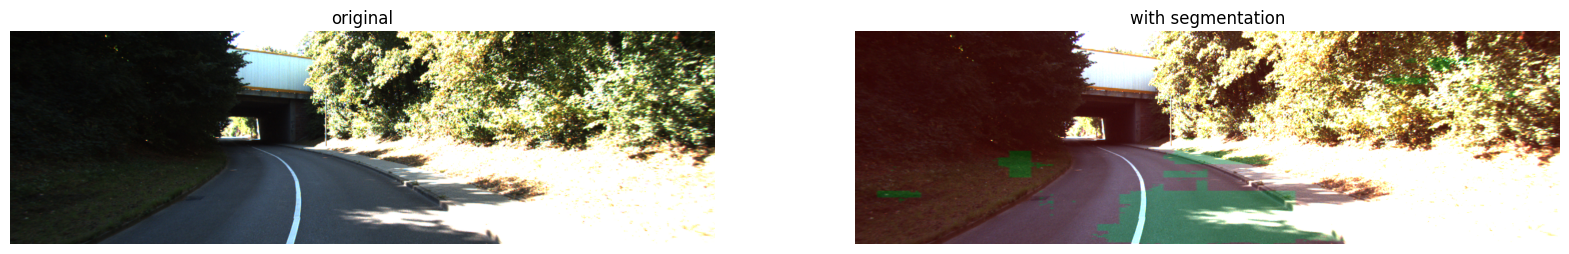

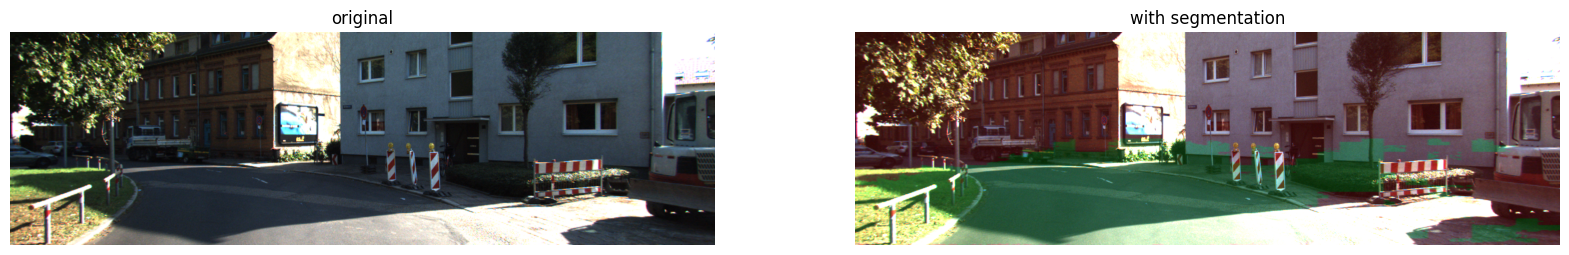

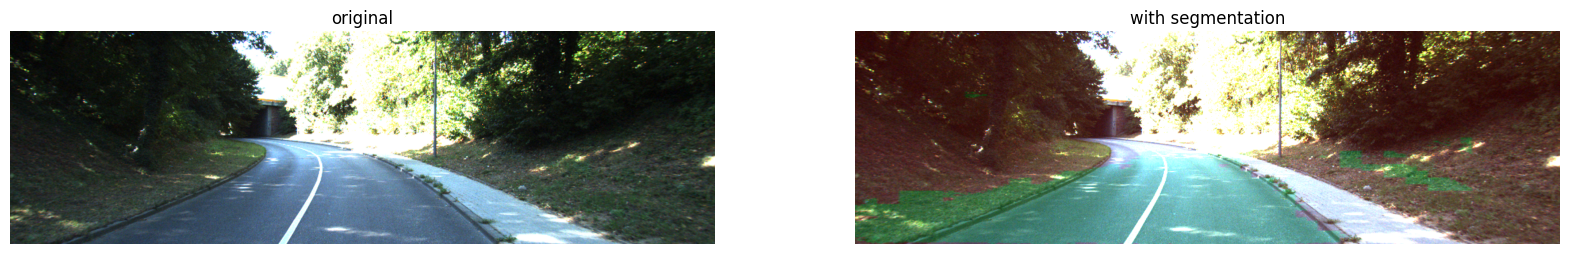

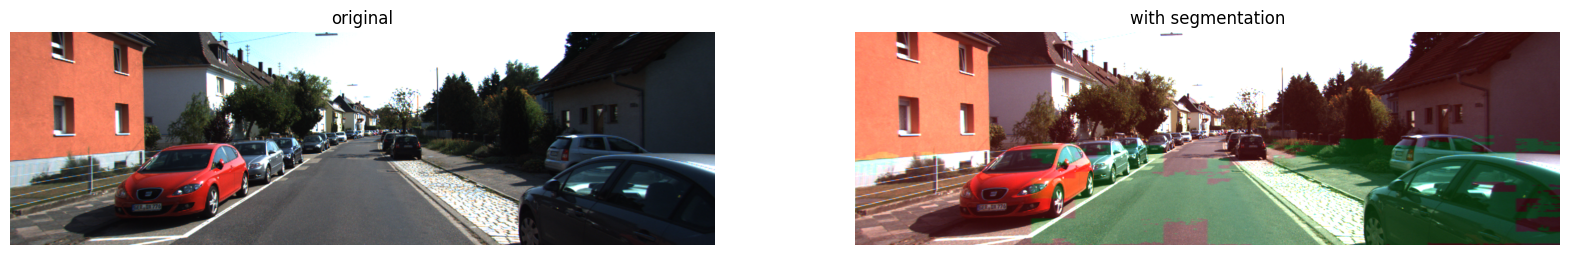

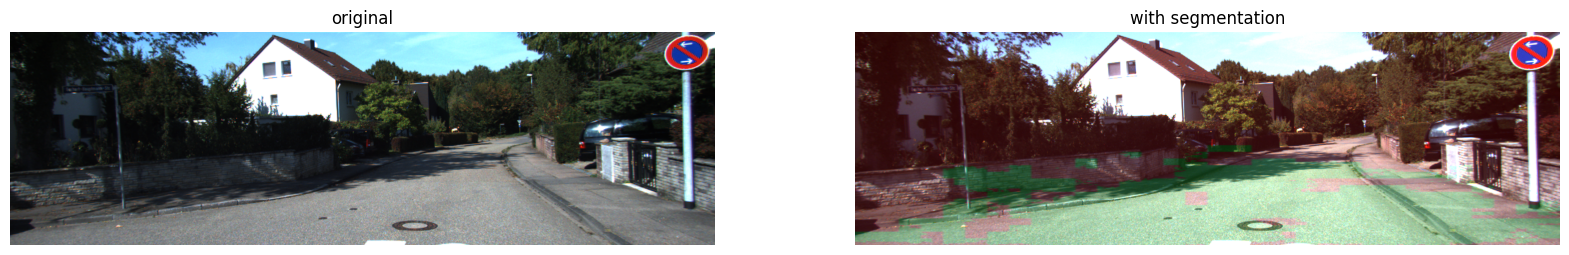

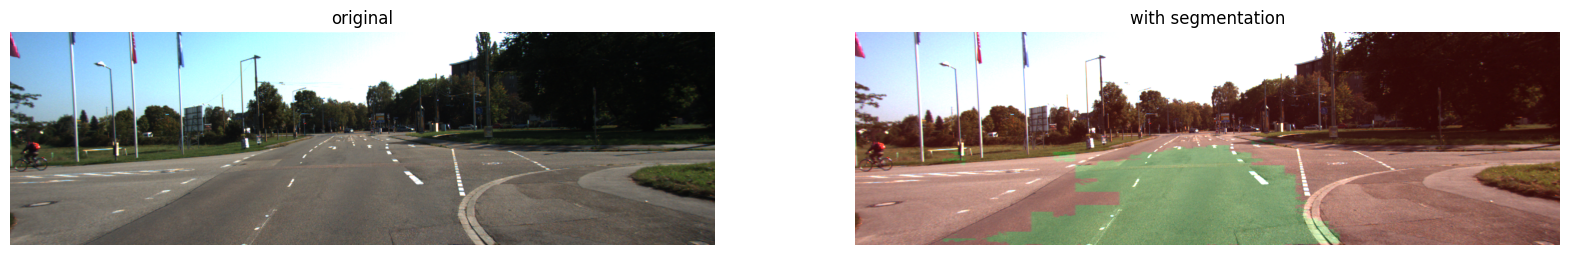

In [264]:
image_paths = glob(os.path.join('./data/data_road/testing/image_2', '*.png'))

# Visualize sample data
best_decoder = Decoder(num_classes=2)
best_decoder.load_state_dict(torch.load(ckpt_name))
best_decoder = best_decoder.to(device)
best_decoder.eval()
# obtain one batch of testing images
test_ds = SegmentationDataset('./data/data_road/testing', 'test', test_tfm)
test_dl = DataLoader(test_ds, batch_size=6, shuffle=True)

with torch.no_grad():
  for images in test_dl:
    images = images.to(device)

    # Pass the inputs through the FCN model.
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
    outputs = best_decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out) # batch_size x num_classes x H x W
    outputs = torch.sigmoid(outputs)

    for index, output in enumerate(outputs):
      # Get the predictions
      pred = output.detach().cpu().numpy()                         # 2 x H x W
      pred = pred.transpose((1, 2, 0))                             # H x W x 2
      pred = pred.argmax(axis=2)
      pred = (pred > 0.5)                                          # retain pixels coming from channel 1 not channel 0 (ind=0)

      # Prepare 3D mask with road detected in light red (channel1), non-road in light green (channel2)
      pred = pred.reshape(*pred.shape, 1)                                      # H x W x 1  True = road, False otherwise
      pred = np.concatenate((pred, np.invert(pred)), axis=2).astype('float')   # H x W x 2  inverse on channel 2
      pred = np.concatenate((pred, np.zeros((*pred[:,:,0].shape, 1))), axis=2).astype('float')  # H x W x 3 channel3 with zeros

      # Channel1 road = 127, 0 elsewhere; channel2 Non-road=127, 0 elsewhere, Channel3 only 0s
      pred[pred == 1.0] = 127.0

      # Combine mask with image
      img = io.imread(image_paths[index])
      pred = cv2.resize(pred, (img.shape[1],img.shape[0]))
      img = np.array(img, dtype='uint8')

      # Merge original image with mask
      street = cv2.addWeighted(img, 0.6, pred, 0.15, 0, dtype = 0)
      street = street/127.0
      street = np.clip(street, 0.0, 1.0)                               # required imshow format: ndarray of integers

      # Display
      plt.figure(figsize=(20,40))
      plt.subplot(1,2,1)
      plt.imshow(img)
      plt.title('original')
      plt.axis('off')
      plt.subplot(1,2,2)
      plt.imshow(street)
      plt.title('with segmentation')
      plt.axis('off')
      plt.show()
    break